In [1]:
import math 

from main import NaiveBayesClassifier
from utils import Message, tokenize 

from io import BytesIO      # so we can treat bytes as a file 
import requests             # to download the files, which 
import tarfile              # are in .tar.bz format 
import glob, re

from typing import List
from collections import Counter 
import random 
import os 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

%matplotlib inline 

# Testing the model 

In [2]:
assert tokenize("Data science is science") == {"data", "science", "is"}    # test if True 

Writing some unit tests for our model to check that it works well: 

In [3]:
# define the train dataset 
messages = [Message("spam rules", is_spam=True), 
            Message("ham rules", is_spam=False), 
            Message("hello ham", is_spam=False)]

model = NaiveBayesClassifier(k=0.5)
model.train(messages)     # train our model 

Let's check that it got the counts right: 

In [4]:
# check all the attributes of our model 
assert model.tokens == {"spam", "ham", "rules", "hello"}    # check the vocabulary 
assert model.spam_messages == 1 
assert model.ham_messages == 2 
assert model.token_spam_counts == {"spam": 1, "rules": 1}
assert model.token_ham_counts == {"ham": 2, "rules": 1, "hello": 1}

Now, let's make a prediction. We'll also go through our Naive Bayes logic by hand, and make sure that we get the same result: 

In [5]:
text = "hello spam"

probs_if_spam = [
    (1 + 0.5) / (1 + 2 * 0.5), # "spam" (present)
    1 - (0 + 0.5) / (1 + 2 * 0.5), # "ham" (not present)
    1 - (1 + 0.5) / (1 + 2 * 0.5), # "rules" (not present)
    (0 + 0.5) / (1 + 2 * 0.5) # "hello" (present)
]

probs_if_ham = [
    (0 + 0.5) / (2 + 2 * 0.5), # "spam" (present)
    1 - (2 + 0.5) / (2 + 2 * 0.5), # "ham" (not present)
    1 - (1 + 0.5) / (2 + 2 * 0.5), # "rules" (not present)
    (1 + 0.5) / (2 + 2 * 0.5), # "hello" (present)
]

p_if_spam = math.exp(sum(math.log(p) for p in probs_if_spam))
p_if_ham = math.exp(sum(math.log(p) for p in probs_if_ham))

p_if_spam / (p_if_spam + p_if_ham)

0.8350515463917525

In [6]:
model.predict(text)

0.8350515463917525

In [7]:
assert model.predict(text) == p_if_spam / (p_if_spam + p_if_ham)

# Using our model

In [2]:
BASE_URL = "https://spamassassin.apache.org/old/publiccorpus"
FILES = ["20021010_easy_ham.tar.bz2",
         "20021010_hard_ham.tar.bz2",
         "20021010_spam.tar.bz2"]

# This is where the data will end up, in
# /spam, /easy_ham and /hard_ham subdirectories. 
# Change this to where you want the data. 
OUTPUT_DIR = 'spam_data'

for filename in FILES: 
    # use requests to get the file contents at each URL
    content = requests.get(f"{BASE_URL}/{filename}").content
    
    # wrap the in-memory bytes so we can use them as a file.
    fin = BytesIO(content)
    
    # extract all the files to the specific output dir 
    with tarfile.open(fileobj=fin, mode='r:bz2') as tf: 
        tf.extractall(OUTPUT_DIR)

In [13]:
os.listdir('spam_data')

['easy_ham', 'hard_ham', 'spam']

In [15]:
for folder in os.listdir('spam_data'): 
    print(len(os.listdir(os.path.join('spam_data', folder))))

2551
250
501


In [16]:
2551 + 250 + 501

3302

- Three folders: spam, easy_ham, and hard_ham. 
- Each folder contains many emails, each contained in a single file. 
- To keep things really simple, we’ll just look at the subject lines of each email.

In [9]:
path = 'spam_data/*/*'

data: List[Message] = []

# glob.glob returns every filename that matches the wildcarded path 
for filename in glob.glob(path): 
    is_spam = 'ham' not in filename                     # determine whether this file is spam or not 
    
    # there are some garbage characters in the emails
    # the erorrs='ignore' skips them instead of raising an exception 
    with open(filename, errors='ignore') as email_file: 
        for line in email_file: 
            if line.startswith("Subject:"): 
                subject = line.lstrip("Subject: ")      # remove "Subject: " at the left of the string
                data.append(Message(subject, is_spam))
                break                                   # done with this file 

In [10]:
print(len(data))     # ignore 2 email having garbage characters 

3300


In [37]:
# Split the data into training data and test data

random.seed(0)       # to get the same answer 

train_msgs, test_msgs = train_test_split(data, test_size=0.25)

print(len(train_msgs))
print(len(test_msgs))

2475
825


In [38]:
model = NaiveBayesClassifier()

model.train(train_msgs)

In [46]:
# generate some predictions and check how our model does 
spam_probs = [model.predict(msg.text) for msg in test_msgs]      # prob of is_spam 

# assume that spam_prob > 0.5 corresponds to spam prediction 
preds = [spam_prob > 0.5 for spam_prob in spam_probs]
labels = [msg.is_spam for msg in test_msgs]

conf_matrix = confusion_matrix(labels, preds)     # labels = [False, True] = [ham, spam]
print(conf_matrix)

[[686  22]
 [ 39  78]]


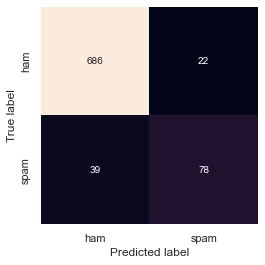

In [47]:
sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['ham', 'spam'], 
            yticklabels=['ham', 'spam'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [44]:
print(classification_report(labels, preds, target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       0.95      0.97      0.96       708
        spam       0.78      0.67      0.72       117

    accuracy                           0.93       825
   macro avg       0.86      0.82      0.84       825
weighted avg       0.92      0.93      0.92       825

